# First coverage tests

We will initially make simple coverage tests in simple examples to see how our proposed test is doing. First we take the boston housing prices dataset:

In [1]:
# importing libraries
from sklearn.datasets import load_boston
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("Set1")

# importing module
os.chdir("/home/kuben/estatistica_UFSCAR/Doutorado/lcv")
from lcv.valid_pred_sets import Valid_pred_sets
from lcv.valid_pred_sets import LinearQuantileRegression
from lcv.valid_pred_sets import GradientBoostingQuantileRegression

## Boston dataset

In [15]:
boston = load_boston()
idx = np.random.permutation(boston.target.size)

# Divide the data into proper training set, calibration set and test set
idx_train, idx_cal, idx_test = idx[:300], idx[300:399], idx[399:]

model = RandomForestRegressor()	# Create the underlying model
nc = NcFactory.create_nc(model)	# Create a default nonconformity function
icp = IcpRegressor(nc)			# Create an inductive conformal regressor

# Fit the ICP using the proper training set
icp.fit(boston.data[idx_train, :], boston.target[idx_train])

# Calibrate the ICP using the calibration set
icp.calibrate(boston.data[idx_cal, :], boston.target[idx_cal])

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dat

In [16]:
boston.data.shape

(506, 13)

Creating our hypothesis object:

In [4]:
# hypothesis object
hyp_obj = Valid_pred_sets(icp, 0.05)

In [5]:
# fitting and testing
hyp_obj.fit(boston.data[idx_test, :], boston.target[idx_test])

Valid_pred_sets(alpha=0.05,
                conf=IcpRegressor(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7ff592f0cc10>,
                                  nc_function=RegressorNc(err_func=<nonconformist.nc.AbsErrorErrFunc object at 0x7ff5bd745610>,
                                                          model=RegressorAdapter(fit_params={},
                                                                                 model=RandomForestRegressor()))))

In [6]:
boston_icp_test = hyp_obj.monte_carlo_test()
boston_icp_test

{'p-value': 0.574, 'Observed statistic': 0.0454545454545455}

Testing quantile regression

In [17]:
# creating quantile regression object
lqr = LinearQuantileRegression(coverage = 0.05)

idx_train, idx_test = idx[:399], idx[399:]

# fitting
lqr.fit(boston.data[idx_train, :], boston.target[idx_train])

LinearQuantileRegression(coverage=0.05)

In [18]:
hyp_quantile_obj = Valid_pred_sets(lqr, 0.05)
hyp_quantile_obj.fit(boston.data[idx_test, :], boston.target[idx_test])

Valid_pred_sets(alpha=0.05, conf=LinearQuantileRegression(coverage=0.05))

In [19]:
boston_quantile_test = hyp_quantile_obj.monte_carlo_test()
boston_quantile_test

{'p-value': 0.33, 'Observed statistic': 0.05863636363636366}

## Simulated datasets
Now we will consider the same simulated datasets generated by Izbicki et.al (2022):

In [2]:
# simulation class
class simulation:
    def __init__(self, dim = 20, coef = 0.3):
        self.dim = dim
        self.coef = coef
    
    def change_dim(self, new_dim):
        self.dim = new_dim
        return self
        
    def homoscedastic(self, n, random_seed = 1250):
        np.random.seed(random_seed)
        X = np.random.uniform(low = -1.5, high = 1.5, size = (n, self.dim))
        y = np.random.normal(self.coef*X[:, 0], scale = 1, size = n)
        self.X, self.y = X, y
    
    def bimodal(self, n, random_seed = 1250):
        np.random.seed(random_seed)
        X = np.random.uniform(low = -1.5, high = 1.5, size = (n, self.dim))
        f_x = (X[:, 0] - 1)**(2)*(X[:, 0] + 1)
        g_x = 2*int(X[:, 0] >= -0.5)*np.sqrt(X[:,0] + 0.5)
        sigma_x = np.sqrt(0.25 + np.abs(X[:0]))
        y = (0.5*np.random.normal(f_x - g_x, scale = sigma_x, size = n) + 
             0.5*np.random.normal(f_x + g_x, scale = sigma_x, size = n))
        self.X, self.y = X, y
    
    def heteroscedastic(self, n, random_seed = 1250):
        np.random.seed(random_seed)
        X = np.random.uniform(low = -1.5, high = 1.5, size = (n, self.dim))
        y = np.random.normal(self.coef*X[:, 0], scale = np.sqrt(1 + self.coef*np.abs(X[:, 0])), size = n)
        self.X, self.y = X, y
    
    def homoscedastic_quantiles(self, X_grid, sig):
        q = [sig/2, 1 - sig/2]
        lower = stats.norm.ppf(np.repeat(q[0], X_grid.shape[0]), loc = self.coef*X_grid, scale = 1)
        upper = stats.norm.ppf(np.repeat(q[1], X_grid.shape[0]), loc = self.coef*X_grid, scale = 1)
        interval = np.vstack((lower, upper)).T 
        return interval
    
    def homoscedastic_r(self, X_grid, B = 1000):
        y_mat = np.zeros((X_grid.shape[0], B))
        for i in range(X_grid.shape[0]):
            y_mat[i, :] = np.random.normal(self.coef*X_grid[i], scale = 1, size = B)
        return y_mat
    
    def heteroscedastic_quantiles(self, X_grid, sig):
        q = [sig/2, 1 - sig/2]
        lower = stats.norm.ppf(np.repeat(q[0], X_grid.shape[0]), loc = self.coef*X_grid, 
                               scale = np.sqrt(1 + self.coef*np.abs(X_grid)))
        upper = stats.norm.ppf(np.repeat(q[1], X_grid.shape[0]), loc = self.coef*X_grid, 
                               scale = np.sqrt(1 + self.coef*np.abs(X_grid)))
        interval = np.vstack((lower, upper)).T 
        return interval
    
    def heteroscedastic_r(self, X_grid, B = 1000):
        y_mat = np.zeros((X_grid.shape[0], B))
        for i in range(X_grid.shape[0]):
            y_mat[i, :] = np.random.normal(self.coef*X_grid[i],
                                           scale = np.sqrt(1 + self.coef*np.abs(X_grid[i])),
                                           size = B)
        return y_mat
    
# shuffling and splitting in train, calibration and test sets
def split(X, y, test_size = 0.4, calibrate = True, random_seed = 1250):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size,
                                                        random_state = random_seed)
    if calibrate:
        X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = 0.25,
                                                             random_state = random_seed)
        return {"X_train":X_train, "X_calib": X_calib, "X_test" : X_test, 
                "y_train" : y_train, "y_calib" : y_calib, "y_test": y_test}
    else:
        return{"X_train":X_train,"X_test" : X_test, 
                "y_train" : y_train,"y_test": y_test}

In [3]:
# testing function
def test_methods(kind = "homoscedastic", n = 10000, d = 20, coef = 2, random_seed = 1250, sig = 0.05,
                coverage_evaluator = "RF"):
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp, split_quantile = split(sim_obj.X, sim_obj.y), split(sim_obj.X, sim_obj.y, calibrate = False)
    
    # testing first icp
    model = RandomForestRegressor(random_state = random_seed)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(split_icp["X_train"], split_icp["y_train"])
    icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
    hyp_icp = Valid_pred_sets(icp, sig, coverage_evaluator = coverage_evaluator)
    hyp_icp.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    res_icp = hyp_icp.monte_carlo_test(random_seed = random_seed)
    
    # testing gradient boosting quantile regression
    gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
    gbqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_gbqr_quant = Valid_pred_sets(gbqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_gbqr_quant.fit(split_quantile["X_test"], split_quantile["y_test"], random_seed = random_seed)
    res_gbqr_quant = hyp_gbqr_quant.monte_carlo_test(random_seed = random_seed)
    
    # testing linear quantile regression
    lqr = LinearQuantileRegression(alpha = 1, solver = "highs")
    lqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_lqr_quant = Valid_pred_sets(lqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_lqr_quant.fit(split_quantile["X_test"], split_quantile["y_test"], random_seed = random_seed)
    res_lqr_quant = hyp_lqr_quant.monte_carlo_test(random_seed = random_seed)
    
    return {"ICP":res_icp, 
            "GB Quantile Reg":res_gbqr_quant, 
            "Linear Quantile Reg":res_lqr_quant}

In [4]:
def plot_intervals(kind = "homoscedastic", 
                   n = 10000, 
                   d = 20, 
                   coef = 2, 
                   random_seed = 1250, 
                   sig = 0.05,
                   alpha = 1):
    # simulating data and then splitting into train and test sets
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp, split_quantile = split(sim_obj.X, sim_obj.y), split(sim_obj.X, sim_obj.y, calibrate = False)
    
    # fitting icp
    model = RandomForestRegressor(random_state = random_seed)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(split_icp["X_train"], split_icp["y_train"])
    icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
    
    # fitting gradient boosting quantile regression
    gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
    gbqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    
    # fitting linear quantile regression
    lqr = LinearQuantileRegression(alpha = alpha, solver = "highs")
    lqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    
    # plotting and comparing to the real quantiles
    # grid elements
    X_grid = np.linspace(-1.5, 1.5, num = 500)
    X_test = np.ones((500, d))
    X_test[:, 0] = X_grid
    
    # intervals
    # ground truth
    quant_kind = getattr(sim_obj, kind + "_quantiles")
    real_int = quant_kind(X_grid, sig)
    # icp
    icp_int = icp.predict(X_test, significance = sig)
    # gbqr
    gbqr_int = gbqr.predict(X_test)
    # lqr
    lqr_int = lqr.predict(X_test)
    
    # plotting
    plt.figure(figsize = (8, 6))
    # ground truth
    plt.plot(X_grid, real_int[:, 0], label = "Ground Truth", color = "royalblue")
    plt.plot(X_grid, real_int[:, 1], color = "royalblue")
    # icp
    plt.plot(X_grid, icp_int[:, 0], label = "ICP", color = "firebrick")
    plt.plot(X_grid, icp_int[:, 1], color = "firebrick")
    # gbqr
    plt.plot(X_grid, gbqr_int[:, 0], label = "GBQR", color = "darkgreen")
    plt.plot(X_grid, gbqr_int[:, 1], color = "darkgreen")
    # lqr
    plt.plot(X_grid, lqr_int[:, 0], label = "LQR", color = "darkorange")
    plt.plot(X_grid, lqr_int[:, 1], color = "darkorange")
    
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$y$")
    plt.legend(loc=1)
    plt.title("Quantiles comparisson for " + kind + " data")
    plt.tight_layout()
    plt.show()

In [5]:
# support function
def r_real(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    for i in range(model_preds.shape[0]):
        r[i] = np.mean(np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1]))
    return r

def plot_r(kind = "homoscedastic", 
           n = 10000, 
           d = 20, 
           coef = 2, 
           random_seed = 1250, 
           sig = 0.05,
           alpha = 1,
            coverage_evaluator = "RF"):
    
    # simulating data and then splitting into train and test sets
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp, split_quantile = split(sim_obj.X, sim_obj.y), split(sim_obj.X, sim_obj.y, calibrate = False)
    
    # fitting icp
    model = RandomForestRegressor(random_state = random_seed)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(split_icp["X_train"], split_icp["y_train"])
    icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
    hyp_icp = Valid_pred_sets(icp, sig, coverage_evaluator = coverage_evaluator)
    hyp_icp.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # fitting gradient boosting quantile regression
    gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
    gbqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_gbqr = Valid_pred_sets(gbqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_gbqr.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # fitting linear quantile regression
    lqr = LinearQuantileRegression(alpha = alpha, solver = "highs")
    lqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_lqr = Valid_pred_sets(lqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_lqr.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # plotting and comparing to the real quantiles
    # grid elements
    X_grid = np.linspace(-1.5, 1.5, num = 500)
    X_test = np.ones((500, d))
    X_test[:, 0] = X_grid
    
    # r estimated values
    # icp
    icp_r = hyp_icp.r_prob(X_test)
    # gbqr
    gbqr_r = hyp_gbqr.r_prob(X_test)
    # lqr
    lqr_r = hyp_lqr.r_prob(X_test)
    
    # r real values
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_grid, B = 100000)
    # icp
    icp_r_real = r_real(icp.predict(X_test, significance = sig), y_mat)
    
    #gbqr
    gbqr_r_real = r_real(gbqr.predict(X_test), y_mat)
    
    # lqr
    lqr_r_real = r_real(lqr.predict(X_test), y_mat)
    
    # gathering all r values into a pandas data frame and then melting it
    r_mat = np.vstack((X_grid, icp_r, icp_r_real, gbqr_r, gbqr_r_real, lqr_r, lqr_r_real)).T
    r_data = pd.DataFrame(data = r_mat, columns = ['grid', "icp_r", 'icp_r_real', 'gbqr_r', 'gbqr_r_real',
                                                  'lqr_r', 'lqr_r_real'])
    
    # melting data
    r_melt = pd.melt(r_data, id_vars = ['grid'])
    names_cols = r_melt["variable"].to_list()
    r_melt["r_method"] = np.where(np.char.find(names_cols, "real") >= 0, 'real', 'estimated')
    r_melt["Model"] = np.where(np.char.find(names_cols, "icp") >= 0, 'icp',
                                   np.where(np.char.find(names_cols, "gbqr") >= 0, 'gbqr', 'lqr'))
    
    # plotting
    # setting wanted color palette
    g = sns.FacetGrid(r_melt, col = "Model", hue = "r_method",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
    
    g.map(sns.lineplot, "grid", "value")
    g.add_legend(loc = "upper right")
    g.set_ylabels(r"$r(x)$")
    g.set_xlabels(r"$x_1$")
    plt.tight_layout()
    plt.show()

### Homoscedastic simulated data

We can now test both quantile regression and inductive conformal prediction for the most simple kind of dataset. We will vary several distribution parameters and dataset settings starting with:
#### $\beta_1 = 2$, $\sigma = 1$ and $d = 20$

Obtaning test results:

In [6]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing:")
res_hom = test_methods()
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing:
Time Elapsed:  4584.569003820419


{'ICP': {'p-value': 0.619, 'Observed statistic': 0.034725},
 'GB Quantile Reg': {'p-value': 0.07,
  'Observed statistic': 0.039124999999999986},
 'Linear Quantile Reg': {'p-value': 0.001,
  'Observed statistic': 0.04330000000000001}}

Plotting each quantile estimate, comparing it to ground truth

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


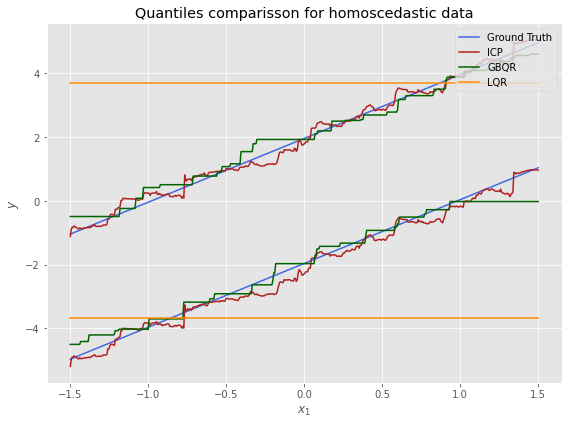

In [84]:
plot_intervals()

Plotting the estimated $\hat{r}(\boldsymbol{x})$ for each method

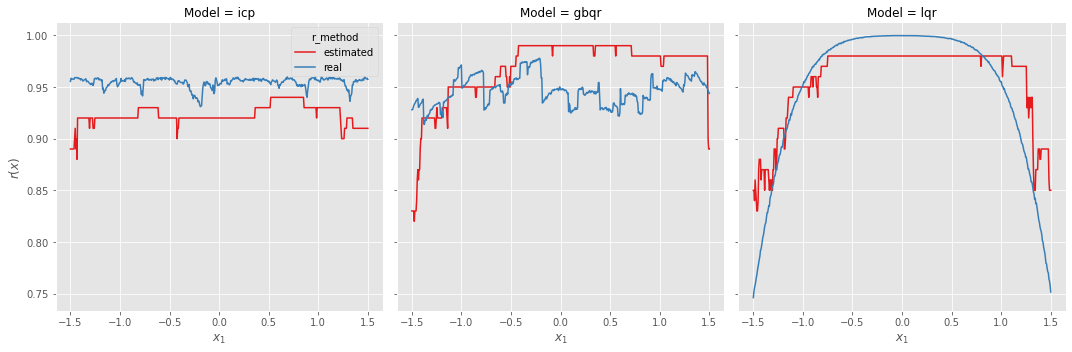

In [10]:
plot_r()

Estimating $\hat{r}(\boldsymbol{x})$ by neural network

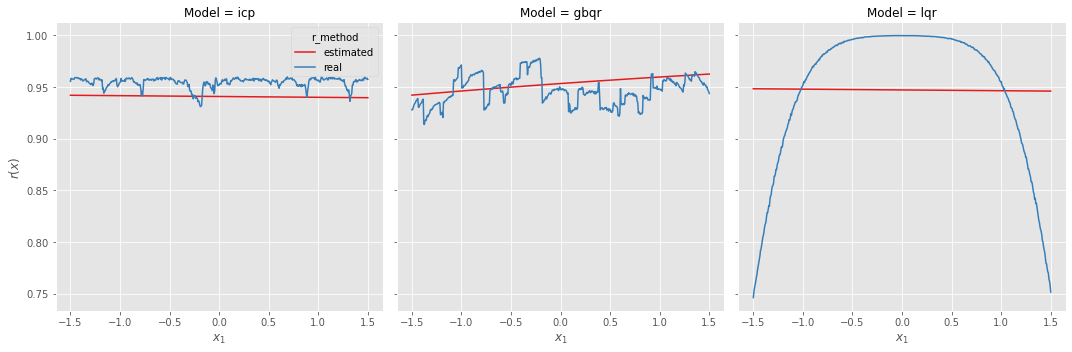

In [11]:
plot_r(coverage_evaluator = "nnet")

Changing $d$ to only 1 to check if results are consistent:

In [90]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing:")
res_hom = test_methods(d = 1)
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing:


/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


Time Elapsed:  1947.2091002464294


{'ICP': {'p-value': 0.952, 'Observed statistic': 0.07310000000000003},
 'GB Quantile Reg': {'p-value': 0.088,
  'Observed statistic': 0.08895000000000003},
 'Linear Quantile Reg': {'p-value': 0.85,
  'Observed statistic': 0.07622500000000004}}

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


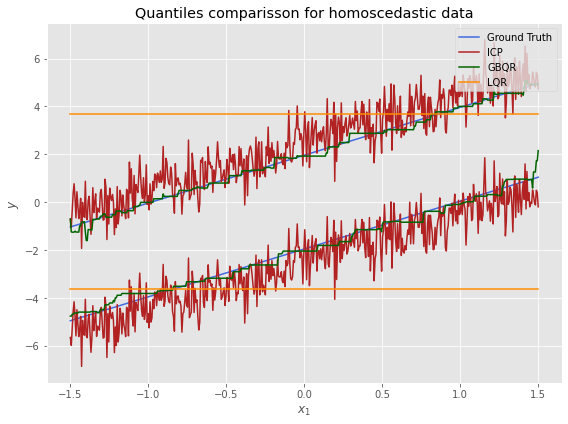

In [91]:
plot_intervals(d = 1)

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


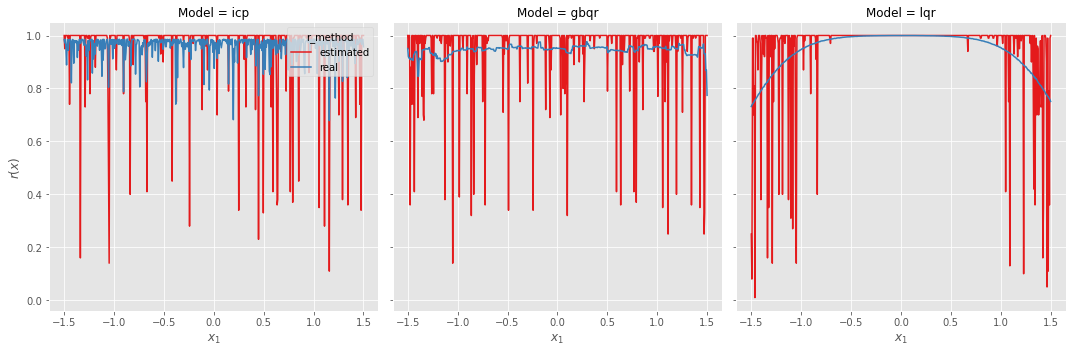

In [92]:
plot_r(d = 1)

$\hat{r}(\boldsymbol{x})$ with neural net

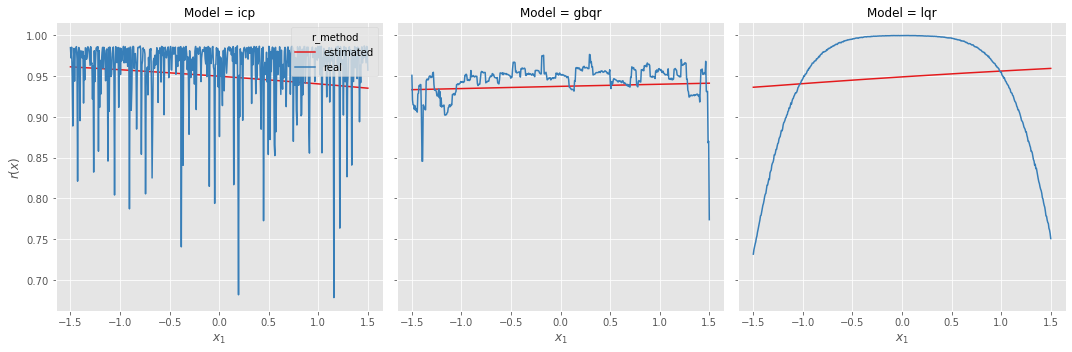

In [12]:
plot_r(d = 1, coverage_evaluator = "nnet")

In [111]:
sim_obj = simulation(dim = 1, coef = 2)
sim_kind = getattr(sim_obj, "homoscedastic")
sim_kind(10000, random_seed = 1250)
split_icp = split(sim_obj.X, sim_obj.y)

model = RandomForestRegressor(random_state = 1250)
nc = NcFactory.create_nc(model)
icp = IcpRegressor(nc)
icp.fit(split_icp["X_train"], split_icp["y_train"])
icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
X_calib, y_calib = split_icp["X_test"], split_icp["y_test"]
preds = icp.predict(X_calib, significance = 0.05)
np.random.seed(1250)
# obtaining each w
w = np.zeros(y_calib.shape[0])
for i in range(y_calib.shape[0]):
    w[i] = int(y_calib[i] >= preds[i, 0] and y_calib[i] <= preds[i, 1])
        # splitting training and testing sets
X_train, X_test, w_train, w_test = train_test_split(X_calib, w, test_size = 0.2)
        
# regressing w on x using random forest model
a = RandomForestClassifier().fit(X_train, w_train)
r = a.predict_proba(X_test)[:, 1]
t_obs = np.mean(np.abs(r  - (1 - 0.05)))

In [104]:
t_obs

0.07310000000000003

In [115]:
np.random.seed(1250)
B = 1250
t_b = np.zeros(B)

for i in range(B):
    new_w = stats.binom.rvs(n = 1, p = 1 - 0.05, size = w_train.shape[0])
    model_temp = RandomForestClassifier().fit(X_train, new_w)
    pred = model_temp.predict_proba(X_test)
    if len(pred[0]) == 1:
        new_r = pred
    else:
        new_r = pred[:, 1]
    t_b[i] = np.mean(np.abs(new_r - (1 - 0.05)))  

In [116]:
(t_b > t_obs).mean()

0.9488

In [118]:
np.mean(t_b)

0.08159073000000003

#### Now testing for $\beta_1 = 0.3$ and $\sigma = 1$

In [76]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing for beta = 0.3:")
res_hom = test_methods(coef = 0.3)
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing for beta = 0.3:


/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


Time Elapsed:  5423.431742668152


{'ICP': {'p-value': 0.569, 'Observed statistic': 0.0349625},
 'GB Quantile Reg': {'p-value': 0.11,
  'Observed statistic': 0.03857499999999999},
 'Linear Quantile Reg': {'p-value': 0.274,
  'Observed statistic': 0.03683749999999999}}

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


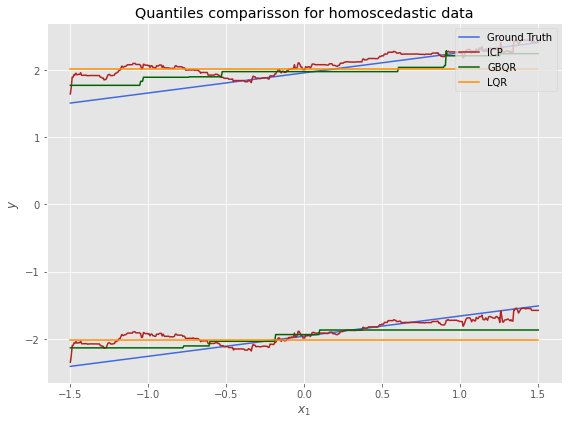

In [86]:
plot_intervals(coef = 0.3)

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


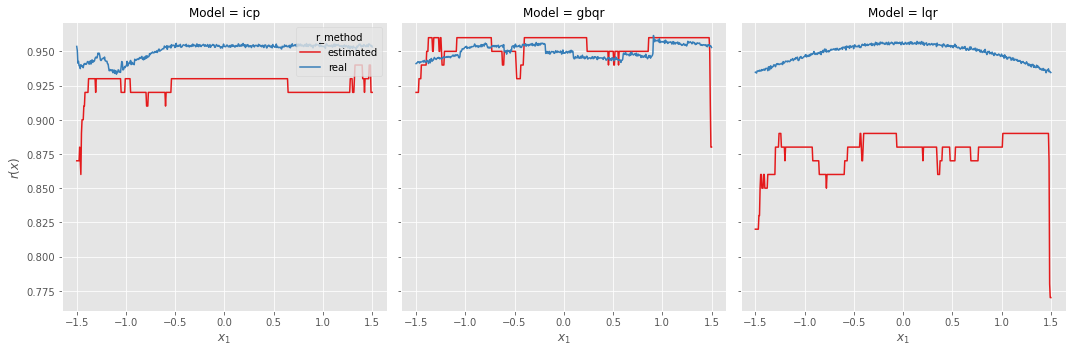

In [87]:
plot_r(coef = 0.3)

### Heteroscedastic simulated data

Now testing both quantile regression and inductive conformal prediction for heteroscedastic dataset. As done in homoscedastic experiments, we will vary some parameters, starting with:
#### $\beta_1 = 2 $ and $\sigma = \sqrt{(1 + 2*|x_1|)}$

In [79]:
# using test_methods
# measuring time
start = time.time()
print("Heteroscedastic data hypothesis testing:")
res_het = test_methods(kind = "heteroscedastic")
end = time.time() - start
print("Time Elapsed: ", end)
res_het

Heteroscedastic data hypothesis testing:


/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


Time Elapsed:  4987.836730480194


{'ICP': {'p-value': 0.327, 'Observed statistic': 0.036474999999999994},
 'GB Quantile Reg': {'p-value': 0.065,
  'Observed statistic': 0.039212499999999983},
 'Linear Quantile Reg': {'p-value': 0.0, 'Observed statistic': 0.0447375}}

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


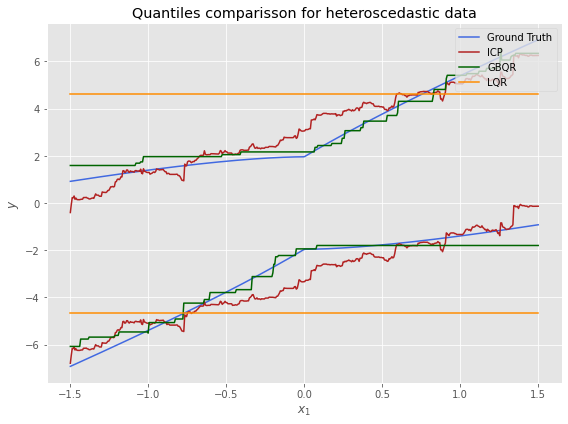

In [88]:
plot_intervals(kind = "heteroscedastic")

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


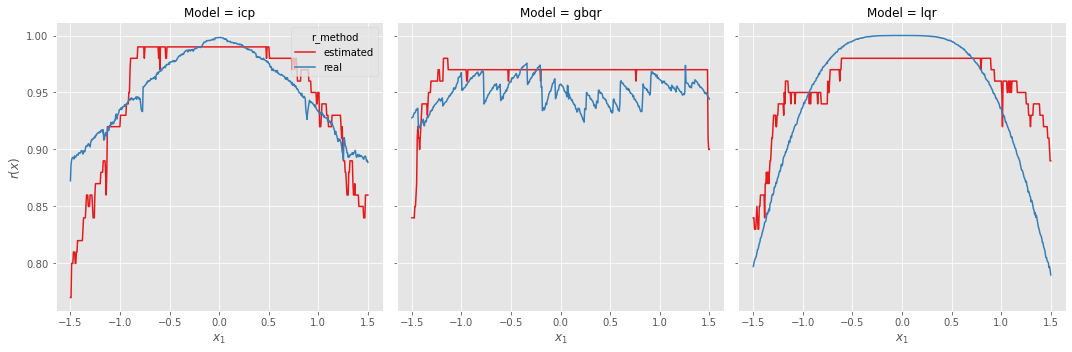

In [89]:
plot_r(kind = "heteroscedastic")